# Stochastic Variational Inference (SVI)
> This post introduce  stochastic gradient based algorithm (SVI) used in practise to do variational inference under mean filed assumptions. It also present two important tricks namely re-parametrization trick and amortized inference that are useful when using SVI in solving problems.
- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/svi.jpg


The [previous post]()  introduced the basic principle of Variational Inference (VI) as one of the approach used to approximate difficult probability distribution, derived the ELBO function and discussed about Mean Field Variational Inference (MFVI) and the Coordinate Ascent Variational Inference (CAVI) algorithms. This post introduce another  stochastic gradient based algorithm (SVI) used in practise to do VI under mean filed assumptions. It also present two important tricks re-parametrization trick and amortized inference that are useful when using SVI in solving problems.

## Stochastic Variational Inference (SVI)
Consider the graphical model of the observations $\mathbf{x}$ and latent variable $\mathbf{z}=\{\theta, z\}$ in figure 1 where $\theta$ is the global variable and $z = \{z_1, \ldots z_n\}$  is the local (per-data-point) variable such that:

![](my_icons/VI.png)

$$
p(\mathbf{x},\mathbf{z}) = p(\theta|\alpha)\prod_{i=1}^N p(x_i|z_i, \theta)\cdot p(z_i|\alpha)
$$ 


Similarly the variational parameters are given by $\lambda = \{\gamma, \phi\} $ where the variational parameter $\gamma$ correspond to latent variable  and  $\phi$ denote set of local variational parameters. The variational distribution $q(\mathbf{z}\mid \phi)$ is given by

$$
q(\mathbf{z}\mid \phi) = q(\theta|\gamma)\prod_{i=1}^N q(z_i|\phi_i, \alpha)
$$

which  also depend on hyper-parameter $\alpha$. The ELBO of this graphical model $\mathcal{L}_{VI}(q) = \mathbb{E}_q[ \log p(\mathbf{x},\mathbf{z}, \alpha) -\log q(\mathbf{z}, \gamma)]$ has the following form:

$$
\begin{split}
\mathcal{L}_{VI}(q) &= \mathbb{E}_q[ \log p(\theta|\alpha)- \log q(\theta|\gamma)] \\
&+ \sum_{i=1}^{N}\mathbb{E}_q[\log p(z_i|\theta) 
+ \log p(x_i|z_i, \theta)-\log q(z_i|\phi_i)]
\end{split}
$$


The equation above could be optimized by CAVI algorithm discussed in previous post which is expensive for large data sets. The CAVI algorithm scales with $N$ as it require to optimize the local variational parameters for each data point before re-estimating the global variational parameters. 

Unlike CAI, SVI uses stochastic optimization to fit the global variational parameters by repeatedly sub-sample the data to form stochastic estimate of ELBO. In every iteration one randomly selects mini-batches of size $b_{sz}$  to obtain a stochastic estimate of ELBO.

$$
\begin{split}
\mathcal{L}_{VI}(q) &= \mathbb{E}_q[ \log p(\theta|\alpha)- \log q(\theta|\gamma)] \\
&+ \frac{N}{b_{sz}}\sum_{s=1}^{b_{sz}}\mathbb{E}_q[\log p(z_{i_s}|\theta) + \log p(x_{i_s}|z_{i_s}, \theta)-\log q(z_{i_s}|\phi_{i_s})]
\end{split}
$$

SVI algorithms follow noisy estimates of the gradient with a decreasing step size which is often  cheaper to compute than the true gradient. Following such noisy estimates allows SVI to escape  shallow local optima of complex objective functions. 

### Natural Gradient for SVI

To solve the optimization problem standard gradient-based methods such as SGD, Adam or Adagrad can be used. However, for SVI these gradient based methods cause slow convergence or converge to inferior local models. This is because, gradient based methods use the following update  

$$
\theta^{t+1}=\theta^t + \alpha \frac{\partial \mathcal{L}_{VI}(q)}{\partial \theta} 
$$

where 

$$
\frac{\partial \mathcal{L}_{VI}(q)}{\partial \theta} =\frac{\partial \mathcal{L}_{VI}(q)}{\partial \theta_1}, \ldots \frac{\partial \mathcal{L}_{VI}(q)}{\partial \theta_k}
$$ 

is the the gradient vector which point in the direction where the function increases most quickly while the changes in the function are measured with respect to euclidean distance. As the result, if the euclidean distance between the variational parameter being optimized is not good measure of variation in objective function then gradient descent will move suboptimal through the parameter value. 

Consider the following  two set of gausian distributions $$\{d_{(1)}=\mathcal{N}(-2, 3), d_{(2)}=\mathcal{N}(2, 3)\}$$ and $$\{d_{(1)}=\mathcal{N}(-2, 1), d_{(2)}=\mathcal{N}(2, 1)\}$$. 

The euclidean distance between the two distributions $d_{}=\sqrt{(\mu_1-\mu_2)^2+ (\sigma^2_1-\sigma^2_2)^2}=4$ It clear that, considering only the euclidean distance the two images are the same. However, when we consider the shape of the distribution, the distance is different in the first and second image. In the first image, the KL-divergence should be lower as there is more overlap between between the two distribution unlike the second image where their support barely overlap. The reason for this difference is that probability distribution do not naturally fit in euclidean space rather it fit on a statistical manifold also called [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold). 

Statistical manifold give a natural way of measuring distances between distribution that euclidean distance use in SGD. A common Riemannian metric for statistical manifold is the [fisher information matrix](https://wiseodd.github.io/techblog/2018/03/11/fisher-information/) defined by 

$$
F_{\lambda} = \mathbb{E}_{p(x;\lambda)}[\nabla \log p(x;\lambda) (\nabla \log p(x;\theta))^T ]
$$

It can be showed that the fisher information matrix $F_{\lambda}$ is  the second derivative of the KL divergence between two distributions.

$$
F_{\theta} = \nabla^2_{\theta} KL(q(x;\lambda)||p(x;\theta))
$$

Thus for SVI, the standard gradients descent techniques can be replaced  with the natural gradient as follows:

$$
        \tilde{\nabla_{q}} \mathcal{L}(q) = F^{-1} \nabla{q}\mathcal{L}_{VI}(q)
$$

The update procedure for natural gradient can be summarized as follows:

1. Compute the loss $\mathcal{L}_{VI}(q)$
2. Compute the gradient of the loss $\nabla{q}\mathcal{L}_{VI}(q)$
3. Compute the Fisher Information Matrix F.
4. Compute the natural gradient $\tilde{\nabla_{q}} \mathcal{L}_{VI}(q)$
5. Update the parameter $q^{t+1} =q^t - \alpha \tilde{\nabla_{\theta}}\mathcal{L}_{VI}(q)$

Using natural gradient instead of standard gradients simplify SVI gradient update. However the same conditions for convergence as standard SDG have to be fulfilled. First, the mini-batch indices must be drawn uniformly at random size where the size $b_{sz}$ of the mini-batch must satisfies $1\leq b_{sz} \leq N$ The learning rate $\alpha$ needs to decrease with iterations $t$ satisying the [Robbins Monro conditions](https://en.wikipedia.org/wiki/Stochastic_approximation) $\sum_{t=1}^{\infty} \alpha_t =\infty$ and $\sum_{t=1}^{\infty} \alpha_t^2 <\infty$ This guarantee that every point in the parameter space can be reached while the gradient noise decreases quickly enough to ensure convergence.

The next section presents two important tricks namely re-parametrization trick and amortized inference that are useful when using SVI in solving problems.


## Re-parametrization trick

Consider the graphical model presented in figure 1, where gradient based stochastic optimization is used to learn the variational parameter $\phi$. For example; for Gaussian distribution  $q_{\phi}(z|x)=\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

To maximize the likelihood of the data, we need to back propagate the loss to the parameter $\phi$ across the distribution of $z$ or across sample $z\sim q_\phi(z \mid x) $ However, it is difficulty to back-propagate through random variable. To address this problem, the re-parametrization trick is used.

First let consider the [Law of the Unconscious Statistician (LOTUS)](https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician), that is used to calculate the expected value of a function $g(\epsilon)$ of a random variable $\epsilon$ when only the probability distribution $p(\epsilon)$ of $\epsilon$ is known. The Law state that: 
>To compute the expectation of a measurable function $g(.)$ of a random variable $\epsilon$, we have to integrate $g(\epsilon)$ with respect to the distribution function of $\epsilon$, that is:

$$
\mathbb{E}(g(\epsilon)) = \int g(\epsilon)dF_{\epsilon}(\epsilon)
$$

In other words, to compute the expectation of $z =g(\epsilon)$ we only need to know $g(.)$ and the distribution of $\epsilon$. We do not need to explicitly know the distribution of $z$. Thus the above equation can be expression in the convenient alternative notation:

$$
\mathbb{E}_{\epsilon \sim p(\epsilon)}(g(\epsilon)) = \mathbb{E}_{z \sim p(z)} (z)
$$

Therefore the reparameteriztaion trick states that:  
>A random variable $z$ with distribution $q_{\phi}(z, \phi)$ which is independent to $\phi$ can be expressed as transformation of random variable $\epsilon \sim p(\epsilon)$ that come from noise distribution such as uniform or gaussian such that $z = g(\phi, \epsilon)$

For instance for Gaussian variable $z$ in the above example 

$$
z = \mu(\phi) + \sigma^2(\phi)\cdot \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, 1)$. Since $p(\epsilon)$ is independent of the parameter of $q_{\phi}(z, \phi)$, we can apply the change of variables in integral theory to compute any expectation over $z$ or any expectation over  $\phi$. The SDG estimator can therefore be estimated by pulling the gradient into expectations and approximating it by samples from the noise 
distribution such that  for any measurable function $f_{\theta}(.)$:

$$
\Delta_{\phi}\mathbb{E}_{z\sim p_{\phi}(z)} = \frac{1}{M}\sum_{i=1}^M \Delta f(g(\phi, \epsilon_i)) 
$$

where $\epsilon_i\sim p(\epsilon)$ , $f_{\theta}(.)$ must be differentiable w.r.t  its input $z$ and $g(\phi, \epsilon_i)$ must exist and be differentiable with respect to $\phi$.

## Amortized Variational Inference

Consider the graphical model presented in figure 1 where ecah data point $x_i$ is governed by its latent variable $z_i$ with variational parameter $phi_i$ such that 

$$
q(\mathbf{z}\mid \phi) = q(\theta|\gamma)\prod_{i=1}^N q(z_i|\phi_i, \alpha)
$$

Using traditional SVI make it necessary to optimize $\phi_i$ for each data point $x_i$. As the results the number parameters to be optimized will grows with the number of observations $x$. This is not ideal for larger datasets. Apart from that, it requires one to re-run the optimization procedure in case of new observation or when we have to perform inference. To address these problem amortized VI introduce a parametrized function that maps from observation space to the parameter of the approximate posterior distribution. 

Amortized VI try to learn from past inference/pre-computation so that future inferences run faster. Instead of approximating separate variables for each data point $x_i$, amortized VI assume that the local variational parameter $\phi$ can be predicted by a parametrized function $f_{\phi}(.)$ of data whose parameters are shared across all data points. Thus instead of introducing local variational parameter, we learn a single parametric function and work with a variational distribution that has the form 

$$
q(\mathbf{z}\mid \phi) = q(\theta|\gamma)\prod_{i=1}^N q(z_i|f_{\phi}(.))
$$

where $f_{\phi}(.)$ is the deep neural net function of $z$


Deep neural network used in this context are called [inference networks](). Therefore amortized inference with inference networks combines probabilistic modelling with representation power of deep learning. Using amortized VI instead of traditional VI, has two important advantages. First the number of variational parameters remain constant with respect to the data size. We only need to specify the parameter of the neural networks which is independent to the number of observations. Second, for new observation or during inference all we need to do is to call the inference network. As the result, we can invest time upfront optimizing the inference network and during inference we use the trained network for fast inference.




## Example

Consider a binary regression problem where we are intrested on predicting whether or not a customer will subscribe a term deposit after the marketing campaign the bank performed.

In [27]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
import torch.nn.functional as F
from pyro.infer import Trace_ELBO, SVI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [28]:
def label_binarize(df):
    bin_enc = LabelBinarizer()
    return bin_enc.fit_transform(df)

def standardize(df):
    std_enc = StandardScaler()
    return std_enc.fit_transform(df)

### Load data

In [29]:
data = pd.read_csv("data/bank.csv")

## Encode target variable
LE=LabelEncoder()
target=LE.fit_transform(data.deposit.values)
features = data.drop(columns="deposit")

# Separate both dataframes into 
numeric_data = data.select_dtypes(exclude="object")
categ_data  = data.drop(columns=numeric_data)
#categ_data = pd.get_dummies(categ_data.values)

In [30]:
for column in categ_data.columns:
    categ_data[column] = label_binarize(categ_data[column].values)
    
columns_int = ["campaign", "pdays", "previous"]
for i, column  in enumerate(columns_int):
    numeric_data[column] = label_binarize(numeric_data[column].values)
    
    
numeric_column = ["age", "balance", "day", "duration"]
for i, column  in enumerate(numeric_column):
    numeric_data[column] = standardize(numeric_data[[column]].values)
    


In [31]:
features = pd.concat([numeric_data, categ_data], 1)
features = torch.tensor(features.values).float()
target   = torch.tensor(target).long()

In [32]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
train, test = next(sss.split(features.numpy(), target.numpy()))

In [33]:
X_train, X_test = features[train], features[test]
y_train, y_test = target[train], target[test]

## Model

In [36]:
from pyro.nn import PyroSample
from torch import nn
from pyro.nn import PyroModule
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features=1):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = torch.sigmoid(self.linear(x).squeeze(-1))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(mean), obs=y)
        return mean

### Guide

In [38]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(features.size(-1), 1)
guide = AutoDiagonalNormal(model)


In [39]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [42]:
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train, y_train.float())
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X_train)))

[iteration 0001] loss: 0.0208
[iteration 0101] loss: 0.0188
[iteration 0201] loss: 0.0167
[iteration 0301] loss: 0.0160
[iteration 0401] loss: 0.0151
[iteration 0501] loss: 0.0146
[iteration 0601] loss: 0.0133
[iteration 0701] loss: 0.0136
[iteration 0801] loss: 0.0135
[iteration 0901] loss: 0.0135
[iteration 1001] loss: 0.0129
[iteration 1101] loss: 0.0137
[iteration 1201] loss: 0.0124
[iteration 1301] loss: 0.0123
[iteration 1401] loss: 0.0125
[iteration 1501] loss: 0.0132
[iteration 1601] loss: 0.0122
[iteration 1701] loss: 0.0120
[iteration 1801] loss: 0.0120
[iteration 1901] loss: 0.0131
[iteration 2001] loss: 0.0121
[iteration 2101] loss: 0.0120
[iteration 2201] loss: 0.0119
[iteration 2301] loss: 0.0118
[iteration 2401] loss: 0.0118
[iteration 2501] loss: 0.0118
[iteration 2601] loss: 0.0114
[iteration 2701] loss: 0.0118
[iteration 2801] loss: 0.0117
[iteration 2901] loss: 0.0119
[iteration 3001] loss: 0.0122
[iteration 3101] loss: 0.0119
[iteration 3201] loss: 0.0118
[iteration

In [43]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

w_loc tensor([-0.0071,  0.0229, -0.0480,  0.8757,  0.0749, -0.9454, -0.9454,  0.0240,
        -0.1021, -0.3675, -0.1923, -0.9378, -0.4416, -0.0203,  0.2147, -1.3860,
         6.3369], requires_grad=True)
w_scale tensor([-1.9725, -2.2263, -1.8859, -1.4443, -1.4062, -1.3978, -1.3952, -1.3166,
        -1.2706, -1.2814, -0.7051, -1.3490, -1.2376, -1.4575, -1.2055, -1.3631,
        -0.8033], requires_grad=True)
b_loc tensor(-0.9499, requires_grad=True)
b_scale tensor(-1.4293, requires_grad=True)
sigma_loc tensor(0.4712, requires_grad=True)
sigma_scale tensor(1.0128, requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.0622e-01, -3.7485e-03, -3.0043e-02, -8.0583e-02,  6.4904e-01,
         1.8374e-01, -3.6323e-01, -3.5512e-01, -2.5773e-02,  5.6965e-02,
        -1.7738e-01,  4.0707e-02, -5.3365e-01, -2.6170e-01,  3.2216e-01,
         4.4906e-02, -2.5154e-01,  1.2037e+01, -5.6873e+00])
AutoDiagonalNormal.scale tensor([1.8662, 0.1736, 0.1103, 0.1989, 0.2169, 0.2756, 0.2084

In [44]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(2.5875), tensor(5.5137), tensor(8.1229)],
 'linear.weight': [tensor([[-1.2086e-01, -1.0444e-01, -2.1471e-01,  5.0276e-01, -2.1774e-03,
           -5.0379e-01, -5.4666e-01, -3.5181e-01, -2.8543e-01, -3.9910e-01,
           -5.1865e-01, -7.2488e-01, -5.0951e-01,  1.7136e-01, -3.3100e-01,
           -5.7217e-01,  1.1849e+01]]),
  tensor([[-3.7485e-03, -3.0043e-02, -8.0583e-02,  6.4904e-01,  1.8374e-01,
           -3.6323e-01, -3.5512e-01, -2.5773e-02,  5.6965e-02, -1.7738e-01,
            4.0707e-02, -5.3365e-01, -2.6170e-01,  3.2216e-01,  4.4906e-02,
           -2.5154e-01,  1.2037e+01]]),
  tensor([[ 0.1134,  0.0444,  0.0535,  0.7953,  0.3697, -0.2227, -0.1636,  0.3003,
            0.3994,  0.0443,  0.6001, -0.3424, -0.0139,  0.4730,  0.4208,  0.0691,
           12.2247]])],
 'linear.bias': [tensor([-5.8226]), tensor([-5.6873]), tensor([-5.5520])]}

In [46]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X_test)
pred_summary = summary(samples)

In [48]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "age": X_test[:, 0],
    "rugged": X_test[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_test,
})

In [55]:
y['mean']

tensor([0.0000, 0.9962, 0.0012,  ..., 0.9987, 0.9950, 0.9975])

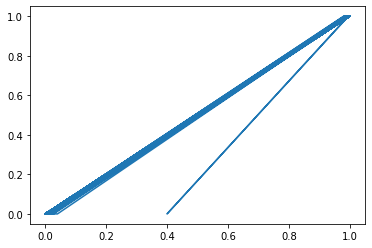

In [58]:
plt.plot(y['mean'], y_test)

In [ ]:
## Reference

1. [[Cheng Zhang,(2017)]](https://arxiv.org/abs/1711.05597):
Advances in Variational Inference.
2. [[Daniel Ritchie,(2016)]](https://arxiv.org/abs/1610.05735):Deep Amortized Inference for Probabilistic Programs.
3. [[Andrew Miller,(2016)]](https://arxiv.org/abs/1610.05735):Natural Gradients and Stochastic Variational Inference.
4.  [Shakir Mohamed](https://www.shakirm.com/papers/VITutorial.pdf):Variational Inference  for Machine Learning. 
5.  [DS3 workshop](https://emtiyaz.github.io/teaching/ds3_2018/ds3.html):Approximate Bayesian Inference: Old and New.
6.  [Variational Inference and Deep Generative Models](https://github.com/philschulz/VITutorial):Variational Inference for NLP audiences
